In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# importing essential libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from time import perf_counter
import cv2
import tensorflow as tf


In [ ]:
dataFrame = {
    'image' : [],
    'box'   : [],
}

In [ ]:
# A composite function for loading and drawing box
# around license plate
from bs4 import BeautifulSoup
def Reader(path, annotPath, size = 256, isPlot = False, showTime = False):

    start = perf_counter()
    img = plt.imread(path)
    img =  np.array (img[:, :, 0:3])

    if isPlot:
        plt.subplot(1, 2, 1)
        plt.imshow(img)

    # parsing html
    with open(annotPath, 'r') as f:
        data = f.read()

    Bs = BeautifulSoup(data, "xml")
    xMax = int (Bs.find('xmax').text)
    xMin = int (Bs.find('xmin').text)
    yMax = int (Bs.find('ymax').text)
    yMin = int (Bs.find('ymin').text)
    #print(xMin, xMax, yMin, yMax, img.shape)
    # storing data
    dataFrame['image'].append  ( cv2.resize(img, (size, size)))
    # drawing box
    #imgBoxed = cv2.rectangle(img, (xMin, yMin), (xMax, yMax), (0 ,255, 0), 2)
    # storing data into frame
    x = yMin
    while x < yMax:
        y = xMin
        while y < xMax:
            img[x, y, 1] = 1
            y += 1
        x += 1

    dataFrame['box'].append (cv2.resize(img, (size, size)))

    if isPlot:
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.resize(imgBoxed, (size,size)))

    if showTime:
        return perf_counter() - start




In [ ]:
# defining Iterator
def Iterator(imageDir, annotDir):
    start = perf_counter()
    imageNames = os.listdir(imageDir)

    for mem in imageNames:
        path = imageDir + '/' + mem
        annotPath = annotDir + '/' + mem.split('.')[0] + '.xml'
        Reader(path, annotPath)

    return perf_counter() - start


In [ ]:
Iterator('/content/drive/MyDrive/Colab Notebooks/License Plate Detection/images' ,'/content/drive/MyDrive/Colab Notebooks/License Plate Detection/annotations')

282.76817794499993

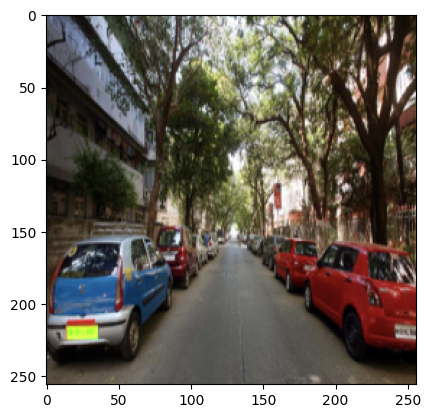

In [ ]:
plt.imshow(dataFrame['box'][3])

In [ ]:
# defining autoencoder model
def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)

    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x =tf.keras.layers.Activation('relu')(x)

    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Activation('relu')(x)

    return x


# Now defining Unet
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)

    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)

    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)

    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)

    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)

    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)

    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)

    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)

    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)

    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)

    output = tf.keras.layers.Conv2D(3, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

In [ ]:
## instanctiating model
inputs = tf.keras.layers.Input((256, 256, 3))
myTransformer = GiveMeUnet(inputs, droupouts= 0.07)
myTransformer.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

In [ ]:
retVal = myTransformer.fit(np.array(dataFrame['image']), np.array(dataFrame['box']), epochs = 50, verbose = 1)

Epoch 1/50
14/14 [==============================] - 42s 841ms/step - loss: 0.6827 - accuracy: 0.3173
Epoch 2/50
14/14 [==============================] - 7s 470ms/step - loss: 0.5715 - accuracy: 0.3512
Epoch 3/50
14/14 [==============================] - 7s 466ms/step - loss: 0.5436 - accuracy: 0.3826
Epoch 4/50
14/14 [==============================] - 7s 470ms/step - loss: 0.5312 - accuracy: 0.4259
Epoch 5/50
14/14 [==============================] - 7s 474ms/step - loss: 0.5236 - accuracy: 0.4488
Epoch 6/50
14/14 [==============================] - 7s 476ms/step - loss: 0.5180 - accuracy: 0.4540
Epoch 7/50
14/14 [==============================] - 7s 477ms/step - loss: 0.5143 - accuracy: 0.4668
Epoch 8/50
14/14 [==============================] - 7s 479ms/step - loss: 0.5111 - accuracy: 0.4811
Epoch 9/50
14/14 [==============================] - 7s 484ms/step - loss: 0.5087 - accuracy: 0.4909
Epoch 10/50
14/14 [==============================] - 7s 485ms/step - loss: 0.5071 - accuracy: 0.506

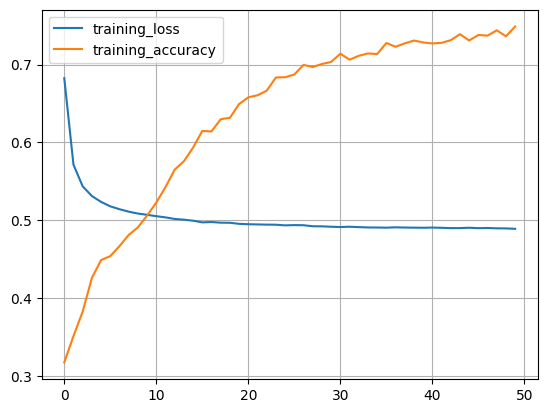

In [ ]:
plt.plot(retVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

In [ ]:
## function for getting 16 predictions
def predict16 (valMap, model, shape = 256):
    ## getting and proccessing val data
    img = valMap['image']
    mask = valMap['box']
    mask = mask[0:16]

    imgProc = img [0:16]
    imgProc = np.array(img)

    predictions = model.predict(imgProc)
    for i in range(len(predictions)):
        predictions[i] = cv2.merge((predictions[i,:,:,0],predictions[i,:,:,1],predictions[i,:,:,2]))

    return predictions, imgProc, mask


def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(20,10))

    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('original Image')

    ## Adding Image sharpening step here
    ## it is a sharpening filter
    filter = np.array([[-1, -1, -1], [-1, 8.99, -1], [-1, -1, -1]])
    imgSharpen = cv2.filter2D(predMask,-1,filter)

    plt.subplot(1,3,2)
    plt.imshow(imgSharpen)
    plt.title('Predicted Box position')

    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('actual box Position')

In [ ]:
sixteenPrediction, actuals, masks = predict16(dataFrame, myTransformer)


 1/14 [=>............................] - ETA: 10s

In [ ]:
Plotter(actuals[1], sixteenPrediction[1], masks[1])

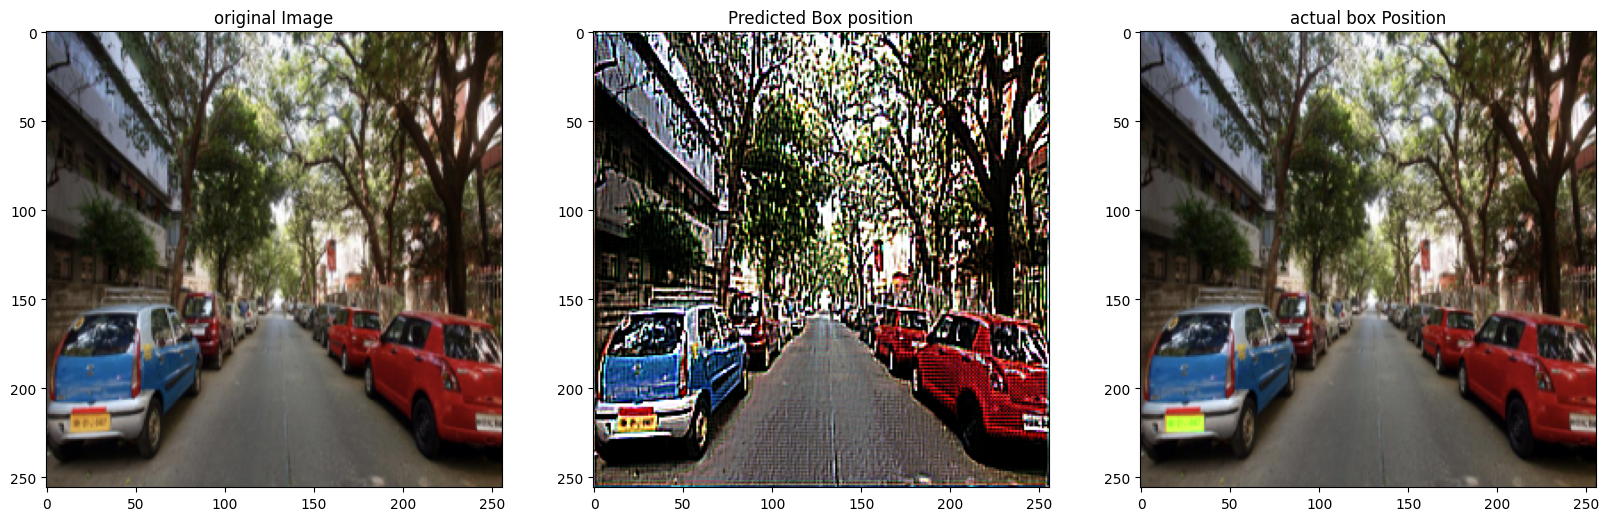

In [ ]:
Plotter(actuals[3], sixteenPrediction[3], masks[3])

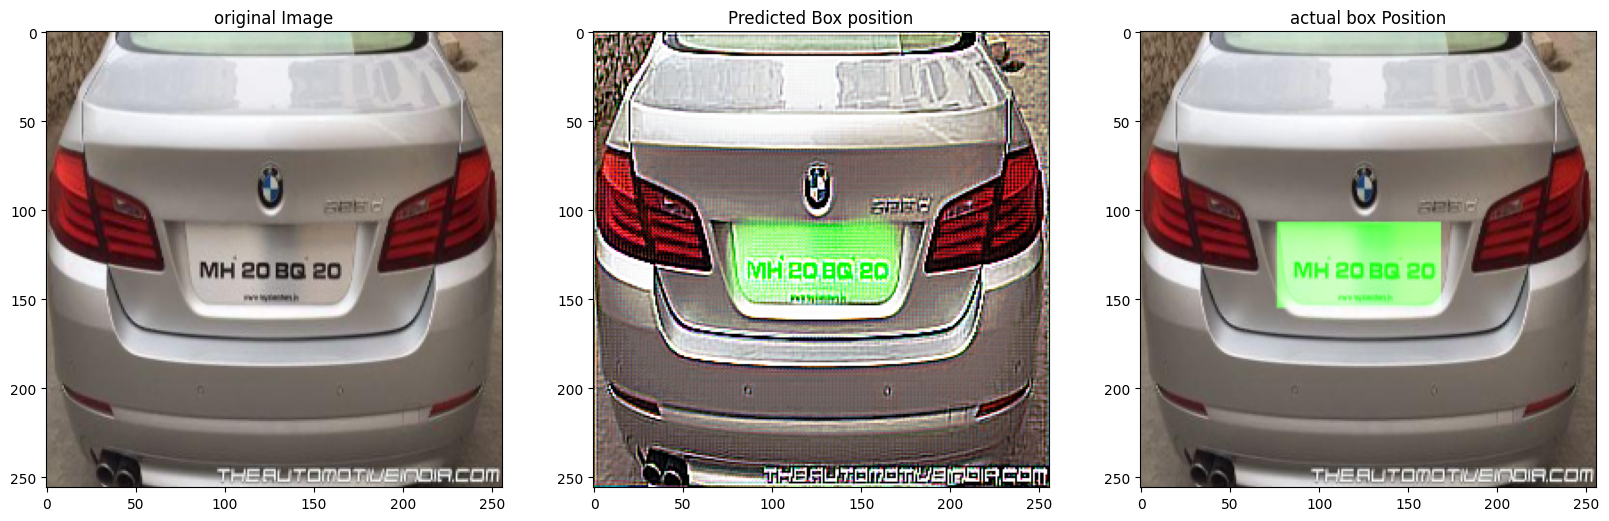

In [ ]:
Plotter(actuals[2], sixteenPrediction[2], masks[2])

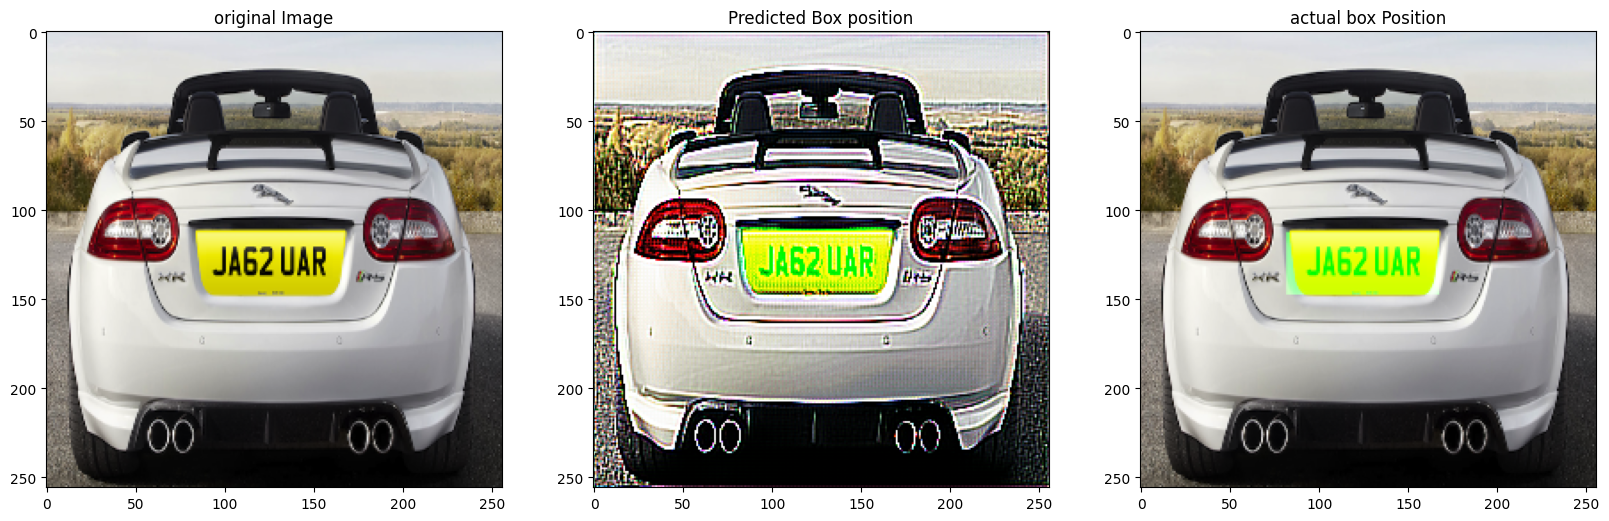

In [ ]:
Plotter(actuals[4], sixteenPrediction[4], masks[4])

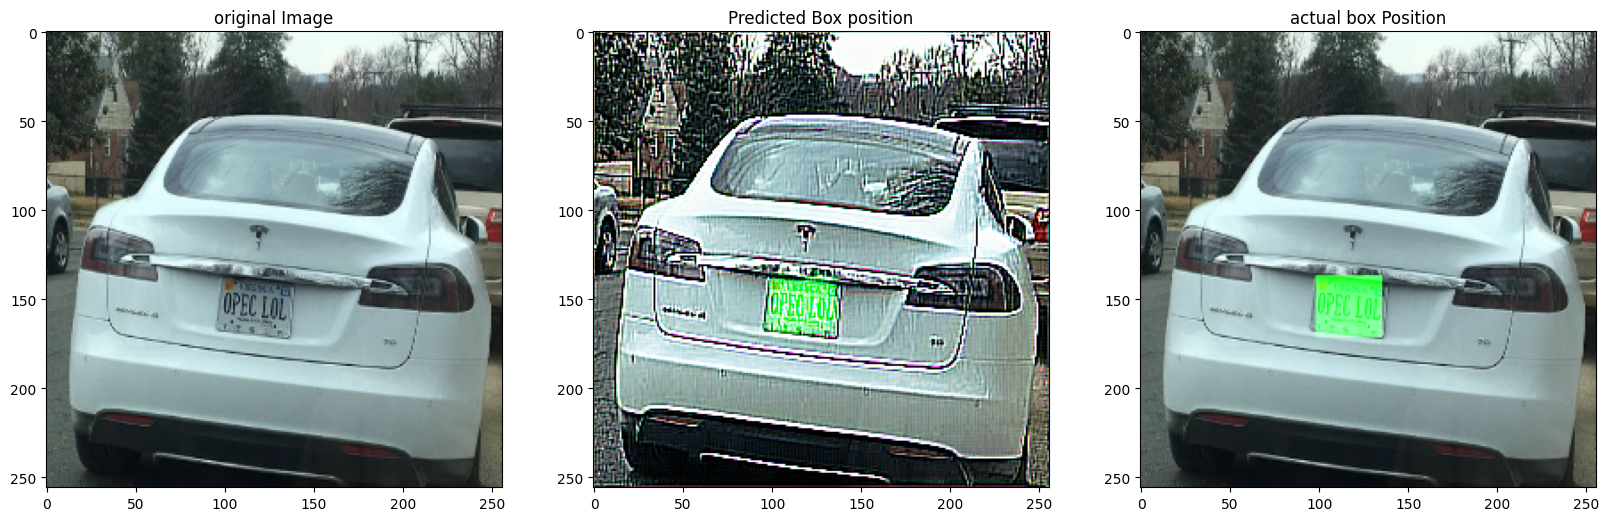

In [ ]:
Plotter(actuals[5], sixteenPrediction[5], masks[5])

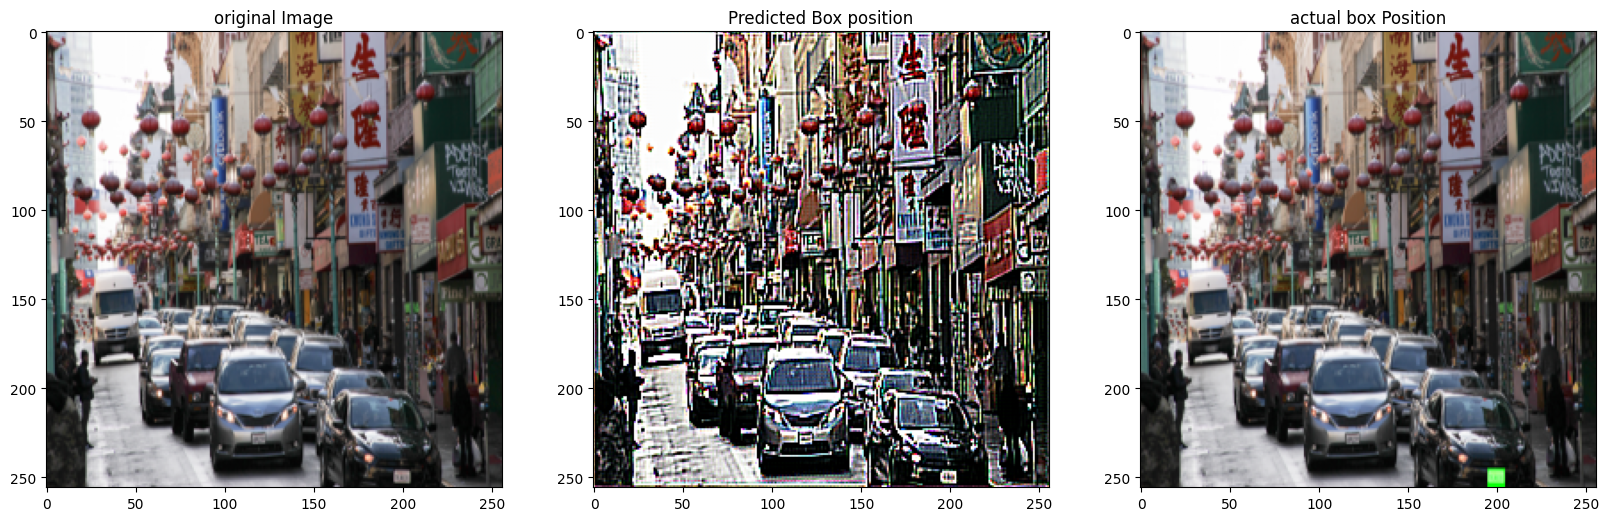

In [ ]:
Plotter(actuals[7], sixteenPrediction[7], masks[7])

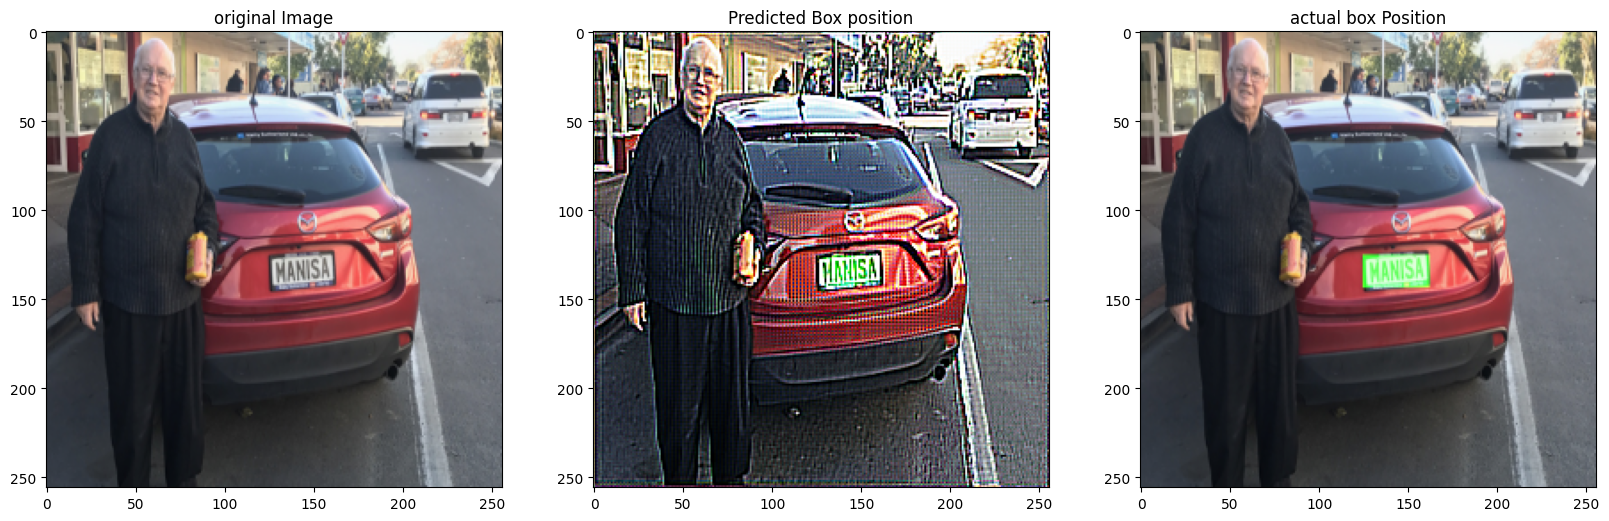

In [ ]:
Plotter(actuals[8], sixteenPrediction[8], masks[8])

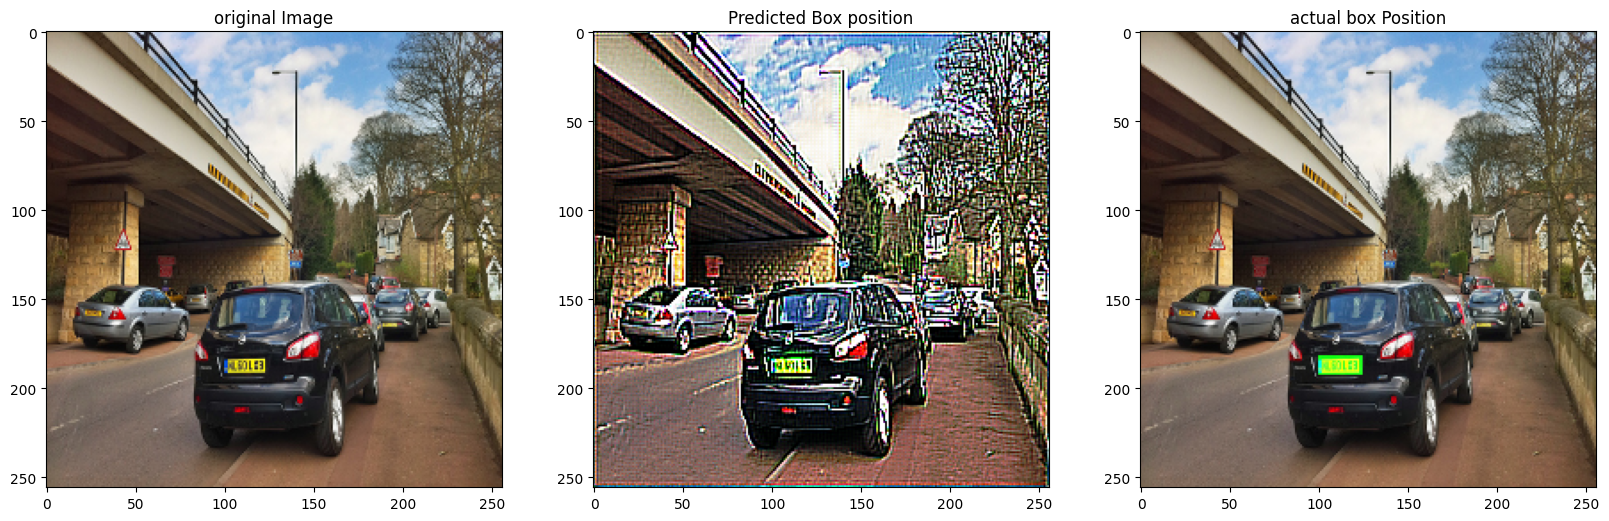

In [ ]:
Plotter(actuals[9], sixteenPrediction[9], masks[9])

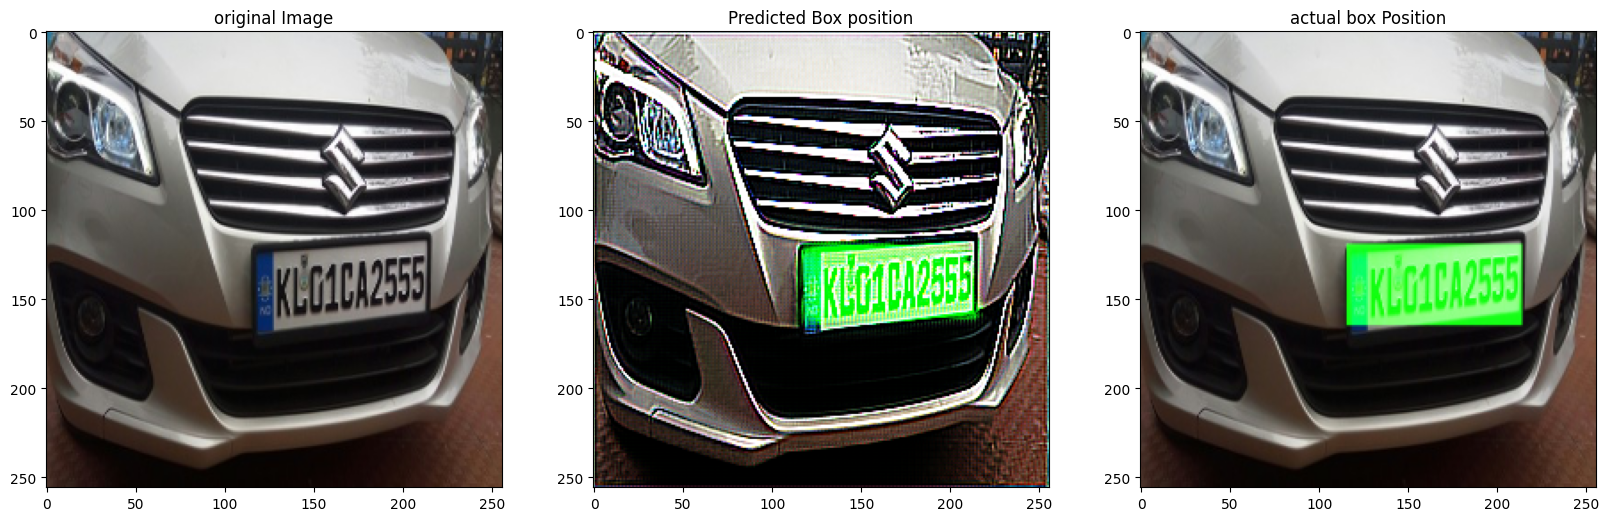

In [ ]:
Plotter(actuals[11], sixteenPrediction[11], masks[11])

In [ ]:
myTransformer.save('/content/drive/MyDrive/Colab Notebooks/License Plate Detection/BetterDetector.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
